In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
import numpy as np
import pandas as pd
import tensorflow as tf

from dice_rl_TU_Vienna.value import get_success_rate, get_get_policy_value
from dice_rl_TU_Vienna.plot.tabular import plot_sr_pv_error, plot_pvs

from dice_rl_TU_Vienna.estimators.get import get_pv_s_OnPE, get_pv_s_OffPE
from dice_rl_TU_Vienna.estimators.tabular.tabular_vafe          import TabularVafe
from dice_rl_TU_Vienna.estimators.tabular.tabular_dice          import TabularDice
from dice_rl_TU_Vienna.estimators.tabular.tabular_dual_dice     import TabularDualDice
from dice_rl_TU_Vienna.estimators.tabular.tabular_gradient_dice import TabularGradientDice

from dice_rl_TU_Vienna.utils.general import iterate_print
from dice_rl_TU_Vienna.utils.os import os_path_join
from dice_rl_TU_Vienna.utils.bedtime import computer_sleep

from plugins.medical_rl.sepsis_amsterdam.tabular.config import *

In [3]:
pd.set_option("display.max_column", 100)

In [ ]:
computer_sleep()

                                          Sleeping now...


# Prepare

In [9]:
dataset_dir = {
    name: os_path_join(
        dir_base,
        id_split, id_clustering, id_policy[name], id_dataset[name],
    )
        for name in iterate_print(names, "name")
}

name=original
name=exploratory
name=evaluation


In [10]:
dataset = {
    name: pd.read_parquet(
        os.path.join(dataset_dir[name], "dataset.parquet"),
    )
        for name in iterate_print(names, "name")
}

name=original
name=exploratory
name=evaluation


In [11]:
success_rate = {}

for name in iterate_print(names, "name"):
    success_rate[name] = get_success_rate(dataset[name])

name=original
name=exploratory
name=evaluation


In [12]:
estimators_OnPE = {}

for name in iterate_print(names, "name"):
    estimators_OnPE[name] = get_get_policy_value(dataset[name])
    estimators_OnPE[name].__name__ = name

name=original
name=exploratory
name=evaluation


In [ ]:
estimators_OffPE = {}
estimators_VAFE  = {}
estimators_DICE  = {}

for name in iterate_print(names, "name"):
    path = dataset_dir[name]

    E = [
        estimator_type(dataset[name], n_obs, n_act, path, verbosity=1)
            for estimator_type in [
                TabularVafe, TabularDice, TabularDualDice, TabularGradientDice, ]
    ]

    estimators_OffPE[name] = E
    estimators_VAFE [name] = E[:1]
    estimators_DICE [name] = E[1:]

name=original
trying to load auxiliary estimates from data/medical_rl/sepsis_amsterdam/2025-01-30T11:42:45.694984/2025-01-30T12:01:58.273325/2025-01-31T12:35:00.823871
loaded data/medical_rl/sepsis_amsterdam/2025-01-30T11:42:45.694984/2025-01-30T12:01:58.273325/2025-01-31T12:35:00.823871/d0_bar.npy
loaded data/medical_rl/sepsis_amsterdam/2025-01-30T11:42:45.694984/2025-01-30T12:01:58.273325/2025-01-31T12:35:00.823871/dD_bar.npy
loaded data/medical_rl/sepsis_amsterdam/2025-01-30T11:42:45.694984/2025-01-30T12:01:58.273325/2025-01-31T12:35:00.823871/P_bar.npy
loaded data/medical_rl/sepsis_amsterdam/2025-01-30T11:42:45.694984/2025-01-30T12:01:58.273325/2025-01-31T12:35:00.823871/r_bar.npy
loaded data/medical_rl/sepsis_amsterdam/2025-01-30T11:42:45.694984/2025-01-30T12:01:58.273325/2025-01-31T12:35:00.823871/n.npy
trying to load auxiliary estimates from data/medical_rl/sepsis_amsterdam/2025-01-30T11:42:45.694984/2025-01-30T12:01:58.273325/2025-01-31T12:35:00.823871
loaded data/medical_rl/se

# `get_pvs`

In [16]:
pvs_OnPE = {
    name: get_pv_s_OnPE(
        estimator_s=estimators_OnPE[name],
        gamma_s=gammas,
    )
        for name in names
}

In [21]:
pvs_VAFE = {}
pvs_DICE_s = {}
pvs_DICE_w = {}

for name in iterate_print(names, "name"):
    print("VAFE")
    pvs_VAFE[name] = get_pv_s_OffPE(
        estimator_s=estimators_VAFE[name],
        gamma_s=gammas,
        projected=projected, weighted=None,
        modified=modified, lamda=lamda,
    )

    print("DICE_s")
    pvs_DICE_s[name] = get_pv_s_OffPE(
        estimator_s=estimators_DICE[name],
        gamma_s=gammas,
        projected=projected, weighted=False,
        modified=modified, lamda=lamda,
    )

    print("DICE_w")
    pvs_DICE_w[name] = get_pv_s_OffPE(
        estimator_s=estimators_DICE[name],
        gamma_s=gammas,
        projected=projected, weighted=True,
        modified=modified, lamda=lamda,
    )

pvs_DICE = { False: pvs_DICE_s, True: pvs_DICE_w, }

name=original
VAFE
DICE_s
DICE_w
name=exploratory
VAFE
DICE_s
DICE_w
name=evaluation
VAFE
DICE_s
DICE_w


# Plots

In [42]:
def plot_pvs_sepsis_amsterdam_tabular(name, weighted):

    estimators = [ estimators_OnPE[name] for name in names ] \
        + estimators_OffPE[name]

    pvs = [ pvs_OnPE[name] for name in names ] \
        + list(pvs_VAFE[name]) + list(pvs_DICE[weighted][name])
    pv_lims = [ success_rate[name] for name in names ]
    pv_ref = None
    pv_lim_ref = None

    labels = None
    colors  = colors_OnPE  + colors_OffPE
    markers = markers_OnPE + markers_OffPE

    measure = "PVs"
    suptitle = f"{env_title} - {name} - {measure}"

    one_minus_gamma = True

    errors = False

    xlabel = None
    a = r"\hat{\rho}^\pi_\text{OffPE}(\gamma)"
    b = r"\hat{\rho}^\pi_\text{OnPE}(\gamma)"
    x = f"| {a} - {b} |"
    y = r"\div (1 - \gamma)"
    ylabel = None if not errors else f"${x} {y}$"

    ylim = [0.1, 0.4]
    scale_x = True
    scale_y = False
    scale_pv = True
    legend = True

    plot_pvs(
        estimators, gammas,
        projected, weighted, modified, lamda,
        pvs, pv_lims, pv_ref, pv_lim_ref,
        labels, colors, colors_lim, markers, markers_lim,
        suptitle,
        one_minus_gamma,
        errors,
        xlabel, ylabel, scale_x, scale_y, scale_pv,
        ylim, legend,
        dir_images,
)

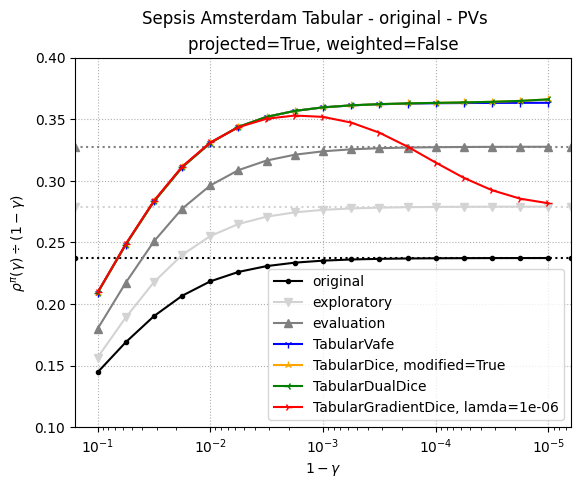

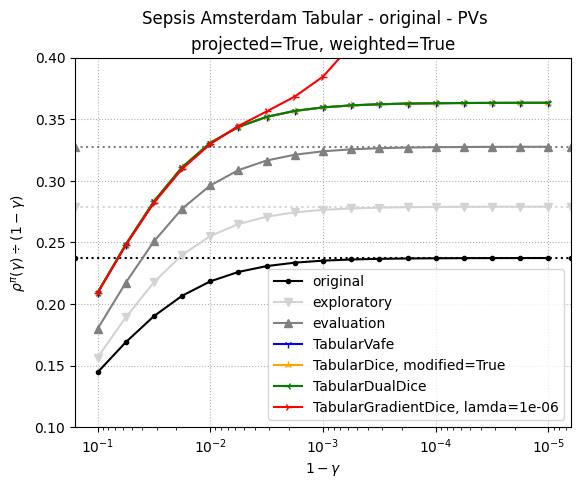

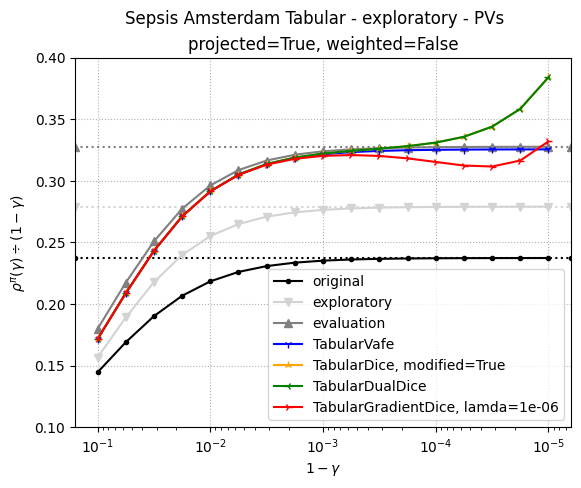

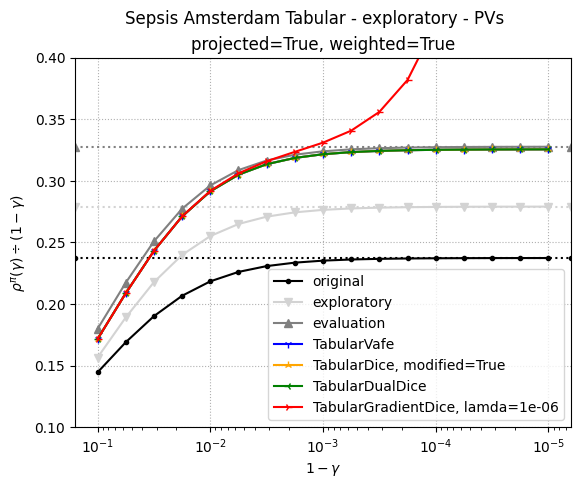

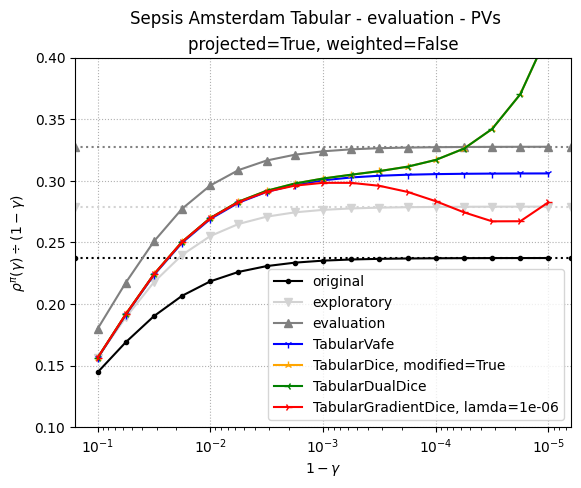

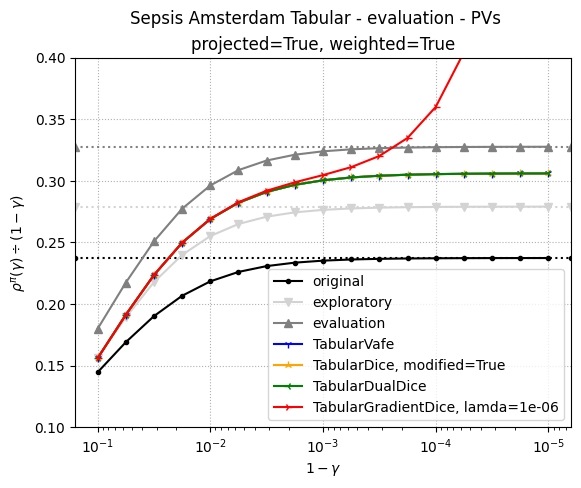

In [50]:
for name in names:
    plot_pvs_sepsis_amsterdam_tabular(name, weighted=False)
    plot_pvs_sepsis_amsterdam_tabular(name, weighted=True)

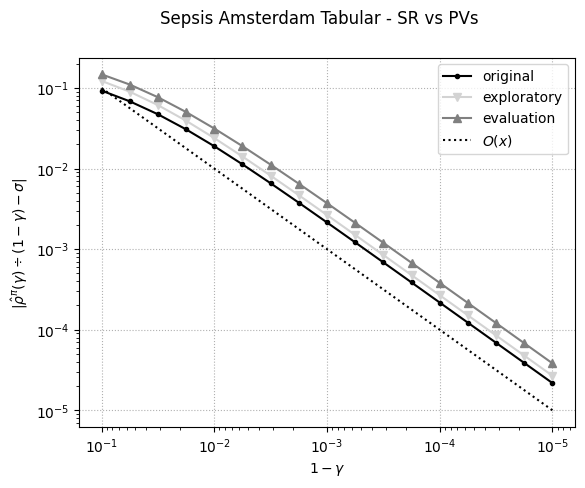

In [49]:
plot_sr_pv_error(
    suptitle="Sepsis Amsterdam Tabular - SR vs PVs",
    success_rates=[ success_rate[name] for name in names ],
    estimators=[ estimators_OnPE[name] for name in names ],
    dir=dir_images,
)

# Test